# Example: Compute the Probability of Profit for a Single Options Contract
Suppose we sold a `DTE = 65-day` put option on `TSLA,` with a strike price of `K = 250 USD/share`, collecting the mid-point premium of `P = 73.25 USD/share` for the sale. Let's use options data and projections of the `TSLA` share price to compute the breakeven point for the contract, i.e., the value of the `TSLA` share price where you start to lose money and the probability of profit (PoP) for the contract.

## Learning objectives
This worked example will familiarize students with probability of profit (PoP) calculations for single options contracts. 
* __Prerequisites__: Before we do any calculations, we'll set values for the `TSLA` contract used in this example, i.e., observed values for the share price, premium, implied volatility, etc.
* __Task 1: Compute breakeven share price__: Next, we'll use our understanding of options contracts and the problem data to compute the breakeven share price for the example `put` contract.
    * `Check`: Are the computed and observed breakeven points equal?
* __Task 2: Estimate the future share price of the underlying asset__: Next, we'll use two approaches: a risk-neutral geometric Brownian motion and a back-of-the-envelope estimate using the implied volatility. Both methods produce a distribution of future share prices that we can use to compute the probability that the price is above or below the break-even share price.
    * `TODO`: Construct a single asset gbm model of TSLA shares assuming a risk-neutral measure using historical volatility. This model can be sampled to produce a future share price distribution.
        * `Check`: Are future GBM share prices log-normally distributed?
    * `TODO`: Construct an approximate future share price projection using the implied volatility.
* __Task 3: Estimate the probability of profit for a TSLA put contract__: Using the price distributions computed in _task 2_, we'll calculate the probability of profit for the `put` option from the buyer's and seller's perspectives.

## Setup
Set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

In [3]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-2/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-2/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-2`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-2/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-2/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Installed NearestNeighbors ─ v0.4.17
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/m

## Prerequisites
Before doing anything else, let's set values for our test `put` option, which was gathered after the market closed on `06-12-2024.` In this example, we'll use options pricing data for a `DTE = 65 day` put option on [Tesla](https://finance.yahoo.com/quote/TSLA/) as the underlying asset, with a strike price of `K = 250.0.` The probability of profit for this `put` contract (from the seller's perspective) is `47%` and `53%` from the buyer's perspective.
* Let's set all the parameters for this contract so we can use them below:

In [5]:
DTE = 65.0; # days to expiration
Sₒ = 178.0; # TSLA underlying share price USD/share
IV = 58.64; # implied volatility
Δt = (1/252); # Time step 1-day
K = 250.0; # strike price for put contract
P = 73.25; # midpoint premium
B = 176.75; # observed midpoint price for put contract
POP = 0.4705; # probability of profit for short put
risk_free_rate = 0.0431; # yield 10-year treasury note on 13-Jun-2024

## Task 1: Compute the break-even points for a short TSLA put
Let's begin by computing the breakeven of the `put` contract. The payoff per share at expiration for a `put` option contract is given by:
$$
\begin{equation}
V_{p}(K,S(T)) = \max\left(K - S(T),~0\right)
\end{equation}
$$
where $K$ denotes the strike price and $S(T)$ is the share price at expiration. 
The `seller` charges the `buyer` a premium $\mathcal{P}_{p}(K,S(0))$ for each contract.
The buyer's profit per share at expiration is the payoff minus the contract premium:
$$
\begin{equation}
P_{p}(K,S(T)) = V_{p}(K,S(T)) -  \mathcal{P}_{p}(K,S(0))
\end{equation}
$$
where $P_{p}(K,S(T)) = 0$ denotes the breakeven point for the buyer. Substituting the payoff and profit expressions into the breakeven equation gives the breakeven share price $\mathcal{B}_{p}$ at expiration for the buyer of the `put` contract:
$$
\begin{equation}
\mathcal{B}_{p} = K - \mathcal{P}_{p}(K,S(0))
\end{equation}
$$
Thus, for the buyer of the `put` contract to make a profit, the share price at expiration must fall below the strike price minus the premium.
* Compute the break-even price for the `put` contract and store this in the `computed_breakeven_price` variable:

In [7]:
computed_breakeven_price = K - P;

### Check: Are the computed and observed breakeven points equal?
The break-even share price was reported in the dataset: $\mathcal{B}_{p}$=`176.75 USD/share`. Let's confirm the value of the `computed_breakeven_price` by comparing this value with the reported value using the [Julia @assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert) in combination with the [Julia isapprox(...) function](https://docs.julialang.org/en/v1/base/math/#Base.isapprox).
* If the observed and `computed_breakeven_price` are _not_ approximately equal to some relative tolerance (specified in the `rtol` argument), then an [AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError) is thrown. 

In [9]:
@assert isapprox(B, computed_breakeven_price, rtol=1e-3)

## Task 2: Estimate the future share price of the underlying asset
The key technical challenge for the calculation of the probability of profit is the prediction of the future share price. However, we have already explored lattice-based and single- and multiple-asset geometric Brownian motion approaches to estimating the distribution of future prices. Here, we start with geometric Brownian motion, and introduce yet another albeit approximate method for future price prediction, namely using the Implied Volatility (IV).

### TODO: Construct a single asset gbm model of TSLA share price
First, load the drift and historic volatility parameters computed in `CHEME 132` using the [read(...) function exported by the CSV.jl package](https://github.com/JuliaData/CSV.jl). The `read(...)` function requires two arguments:
* The first argument is the path to the parameters file; in this module, this file is in the `/<root>/data/gbmparameters` directory. Second, we need to pass a data type to the `read(...)` function; in this case, we use the [DataFrame type exported by the DataFrames.jl package](https://github.com/JuliaData/DataFrames.jl) to hold the parameter data.
* Each row in the `parameters_df::DataFrame` variable holds a ticker, a value for the drift parameter, and a volatility estimate. To access these values, check out the [DataFrame.jl documentation](https://dataframes.juliadata.org/stable/).

In [12]:
parameters_df = CSV.read(joinpath(_PATH_TO_DATA, "gbmparameters", "Parameters-SP500-2018-2023.csv"), DataFrame)

Row,ticker,drift,volatility
,String7,Float64,Float64
1,A,0.151876,0.183345
2,AAL,-0.207376,0.353988
3,AAP,-0.0458017,0.221122
4,AAPL,0.291789,0.262843
5,ABBV,0.118954,0.170957
6,ABT,0.104121,0.157652
7,ACN,0.145112,0.164483
8,ADBE,0.136256,0.216782
9,ADI,0.13822,0.280011


Next, we'll build an instance of the [MyGeometricBrownianMotionEquityModel type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyGeometricBrownianMotionEquityModel) which holds values for the drift `μ` and volatility `σ` parameters using a [custom build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.build-Tuple{Type{MyGeometricBrownianMotionEquityModel},%20NamedTuple}). We set the drift parameter to the risk-free rate (because options use a risk-neutral probability measure), and the volatility is set to the historic volatility estimate. 
* To access the historical volatility, we use the [filter(...) function exported by the DataFrames.jl package](https://dataframes.juliadata.org/stable/lib/functions/#Base.filter) to select the row corresponding to `TSLA,` we then access the volatility value from that row. Note: the [filter(...) function](https://dataframes.juliadata.org/stable/lib/functions/#Base.filter) returns an array, in this case with only one value, so use the [Julia first(...) function](https://docs.julialang.org/en/v1/base/collections/#Base.first) to get the value.

In [14]:
model = build(MyGeometricBrownianMotionEquityModel, (
    μ = risk_free_rate,
    σ = filter(:ticker=> x-> x=="TSLA", parameters_df)[!,:volatility] |> first # historical volatility
));

Now that we have a populated [MyGeometricBrownianMotionEquityModel instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyGeometricBrownianMotionEquityModel) holding the `TSLA` data, let's generate `number_of_samples` possible future share price values using the [sample(...) function exported by the VLQuantitativeFinancePackage.jl package](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyMultipleAssetGeometricBrownianMotionEquityModel,%20NamedTuple}).
* The [sample method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyMultipleAssetGeometricBrownianMotionEquityModel,%20NamedTuple}) takes a `model::MyGeometricBrownianMotionEquityModel` instance as the first argument, along with the time values that we wish to sample: `T₁::Float64` is the start time, `T₂::Float64` is the stop-time (in units of `years`), `Δt::Float64` is the time step (in units of `years`), and `Sₒ::Float64` denotes the initial share price (in units of `USD/share`). Finally, we pass in the number of samples we want to generate in the `number_of_paths` argument.
* The [sample method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyMultipleAssetGeometricBrownianMotionEquityModel,%20NamedTuple}) generates `number_of_paths` sample paths from $T_{1}\rightarrow{T}_{2}$ in steps of $\Delta{t}$. However, we only want the share prices corresponding to the duration of the contract, i.e., $T_{2} = \text{DTE}$. Thus, we pass the full `samples` array [using the Julia pipe operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping) to a slicing operation where we select columns `2:end` of the last row (col 1 holds the time). We store the `number_of_paths` samples of the share price at $T_{2}$ in the `endpoint::Array{Float64,1}` variable.

In [16]:
number_of_samples = 5000;
endpoint = VLQuantitativeFinancePackage.sample(model, (
    T₁ = 0.0,
    T₂ = (DTE)*(Δt),
    Δt = Δt,
    Sₒ = Sₒ
), number_of_paths = number_of_samples) |> samples -> samples[end,2:end]; # get last row from col 2 -> number_of_paths

#### Check: Are future GBM share prices log-normally distributed?
We expect geometric Brownian motion to generate log-normally distributed share prices. However, we can check this expectation by performing an [exact one-sample Kolmogorov-Smirnov-test](https://juliastats.org/HypothesisTests.jl/stable/nonparametric/#Kolmogorov-Smirnov-test) on the samples and a [LogNormal distribution estimated using maximum-likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation). 
* The `H0:null-hypothesis` for the test is the data (endpoint samples generated using geometric Brownian motion) comes from the LogNormal distribution `d.` The alternative hypothesis `H1:alternative`is the samples are not drawn from the distribution `d`.

Let's start this check by fitting a [LogNormal distribution exported by the Distributions.jl package](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.LogNormal) using the [fit_mle(...) function exported by Distributions.jl](https://juliastats.org/Distributions.jl/stable/fit/#Distributions.fit_mle-Tuple{Any,%20Any}), and save this in the `d_gbm` variable:

In [18]:
d_gbm = fit_mle(LogNormal, endpoint);

Next, execute [the exact Kolmogorov–Smirnov test](https://juliastats.org/HypothesisTests.jl/stable/nonparametric/#HypothesisTests.ExactOneSampleKSTest) and check the [pvalue](https://en.wikipedia.org/wiki/P-value) using the [Julia @assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert). We reject the `H0:null-hypothesis`, i.e., the `endpoint` samples are drawn from `d_gbm` if the `pvalue` generated by the test is _less than_ some confidence cutoff, e.g.,`99%` or `0.01.`

In [60]:
test_result = ExactOneSampleKSTest(endpoint, d_gbm)

Exact one sample Kolmogorov-Smirnov test
----------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.00888892

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.8210

Details:
    number of observations:   5000


In [62]:
@assert test_result |> pvalue > 0.01 # if this passes, then S ~ d_gbm

`Unihide` the code block below to see how we plotted the future share price of `TSLA` generated using a risk-neutral single asset geometric Brownian motion model parameterized using historical volatility.
* __Summary__: the geometric Brownian motion generates future share prices that are [log-normally distributed](https://en.wikipedia.org/wiki/Log-normal_distribution) (blue line) (confirmed by the `check` above). The [maximum-likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) of the distribution parameters produces a model that describes the simulated endpoint share price distribution (red line).

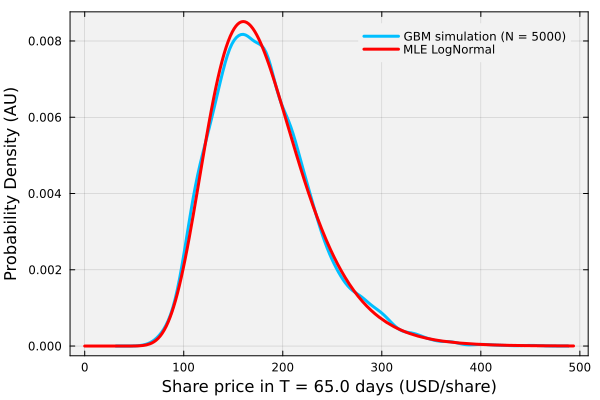

In [22]:
let
    density(endpoint, lw=3, c=:deepskyblue1, label="GBM simulation (N = 5000)")
    plot!(d_gbm, lw=3, label="MLE LogNormal", c=:red, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    xlabel!("Share price in T = $(DTE) days (USD/share)", fontsize=18)
    ylabel!("Probability Density (AU)", fontsize=18)
end

### TODO: Future share price projection using the implied volatility
Alternatively, we can construct a [Normal distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal) with mean $S_{\circ}$ and standard deviation $\sigma_{IV}$ where:
$$
\sigma_{IV} = S_{\circ}\cdot\left(\frac{\text{IV}}{100}\right)\cdot\sqrt{\text{T}\cdot\Delta{t}}
$$
using the [Normal type exported by the Distributions.jl package](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal). Let's save the Normal IV distribution distribution $\mathcal{N}(S_{\circ},\sigma_{IV})$ in the `d_IV` variable:

In [24]:
d_IV = Normal(Sₒ, Sₒ*(IV/100)*sqrt(DTE*Δt));

`Unhide` the code block below to see how we plotted the `d_gbm` and `d_IV` future share price densities at `T = 65 days.`  
* __Summary__: 

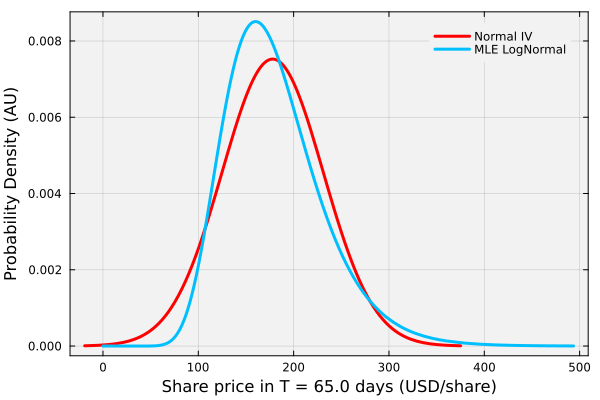

In [77]:
let
    plot(d_IV, lw=3, label="Normal IV", c=:red, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    plot!(d_gbm, lw=3, label="MLE LogNormal", c=:deepskyblue1)
    xlabel!("Share price in T = $(DTE) days (USD/share)", fontsize=18)
    ylabel!("Probability Density (AU)", fontsize=18)
end

## Task 4: Estimate the probability of profit for a TSLA put contract
There are two cases that we consider when exploring the probability of profit: the buyer's and seller's perspectives:
* __Buyer's perspective__: the `TSLA` share price `T` days from now $S(T)$, must be _less than_ the breakeven price $\mathcal{B}_{p}$ for the `put` contract to be profitable. Thus, the probability of profit can be calculated directly from the [cumulative distribution function of the share price](https://en.wikipedia.org/wiki/Cumulative_distribution_function), i.e., $F_{S}(\mathcal{B}_{p}) = P(S\leq{B}_{p})$.
* __Seller's perspective__: the `TSLA` share price `T` days from now $S(T)$, must be _greater than_ the breakeven price $\mathcal{B}_{p}$ for the `put` contract to be profitable. Thus, the probability of profit can be calculated from the [complementary cumulative distribution function of the share price](https://en.wikipedia.org/wiki/Cumulative_distribution_function), i.e., $P(S>{B}_{p}) = 1 - F_{S}(\mathcal{B}_{p})$.

We can query the [cumulative distribution function $F_{S}(\mathcal{B})$]() using the [cdf(...) function exported by the Distributions.jl package](https://github.com/JuliaStats/Distributions.jl?tab=readme-ov-file). We can sample the cdf for both the projected geometric Brownian motion model and the Implied Volatility price distributions.

### TODO: Probability of profit (PoP) table
`Unhide` the code block below to see how we developed a table displaying the probability of profit calculations using the risk-neutral geometric Brownian motion and IV-based price distributions. 

In [29]:
let 
    table_df = DataFrame()

    # buyer -
    buyer_row_df = (
        sense = "buyer",
        ticker = "TSLA",
        DTE = 65,
        Sₒ = Sₒ,
        K = K,
        B = B,
        POP_GBM = cdf(d_gbm, B),
        POP_IV = cdf(d_IV, B),
        POP_observed = 1 - POP
    );
    push!(table_df, buyer_row_df)
    
    # seller -
    seller_row_df = (
        sense = "seller",
        ticker = "TSLA",
        DTE = 65,
        Sₒ = Sₒ,
        K = K,
        B = B,
        POP_GBM = 1 - cdf(d_gbm, B),
        POP_IV = 1 - cdf(d_IV, B),
        POP_observed = POP
    );
    push!(table_df, seller_row_df)
end

Row,sense,ticker,DTE,Sₒ,K,B,POP_GBM,POP_IV,POP_observed
,String,String,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,buyer,TSLA,65,178.0,250.0,176.75,0.527911,0.490594,0.5295
2,seller,TSLA,65,178.0,250.0,176.75,0.472089,0.509406,0.4705


## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. You should decide solely based on your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.